In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
## imports external
import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from os import listdir, mkdir
import os
import numpy as np
import time
import pickle
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
## imports own
from cyclegan.cyclegan import cyclegan
from dataset import load_realdata
from imageGenerators.imgGen_augmented import synth_generator as synth_generator_new

In [4]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

In [5]:
## dimensions, shape
IMAGE_DIMENSIONS = (512, 128)
N_CHANNELS = 1
#              height,              width,               channels
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], N_CHANNELS)

# how many images to generate
N_IMAGES = 20

In [6]:
# which cyclegan model to use
models = [
    # generate easy images
    "synth2easy",
    # generate difficult images using 1 model
    "synth2diff_1step",    
    # generate difficult images using 2 models
    "synth2diff_2steps"
]

model = "synth2diff_2steps"

assert model in models

In [ ]:
## labels
useRandomLabels = True

if useRandomLabels:
    labels = np.random.randint(0,20,(N_IMAGES,5))
else:
    labels = [
        [d for _ in range(5)] for d in range(20)
    ]

In [7]:
# show single image
def showImage(image, normalized=False):
    if normalized:
        vmin=-1; vmax=1
    else:
        vmin=0; vmax=255
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image[:,:,0]
    #image = image.astype(int)
    plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    plt.show()

In [8]:
# given array of labels <digits>,
# return array of generated synthetic images
def generate_synthetic(digits, show_generated=0):
    synthGenerator = synth_generator_new()    
    synth = synthGenerator.makeImages(digits, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    return synth

In [9]:
# load cyclegan model and translate images
def translate(model, images_synth):   
    
    if model == "synth2diff_2steps":
        cgInput = translate("synth2diff_2step_A", images_synth)
        model = "synth2diff_2step_B"
    else:
        cgInput = images_synth
    
    # load model
    cgModel = cyclegan(image_shape=IMAGE_SHAPE,
                   n_images=-1,
                   batchsize=1,
                   adversial_loss="mse",
                   lr=-1,
                   _lambda=-1,
                   poolsize=-1,
                   checkpoint_path=model,
                   smallModel=True,
                   load_checkpoint_after_epoch=None
                  )
    # prepare input
    cgInput =  tf.data.Dataset.from_tensor_slices(cgInput)\
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE)\
        .cache()\
        .batch(1)
    
    # translate
    translated_images = cgModel.gen_AtoB.predict(cgInput)
    # denormalize
    translated_images = (translated_images + 1) * 127.5
    
    return translated_images

In [10]:
images_synth = generate_synthetic(labels)
images_gen = translate(model, images_synth)

loaded checkpoint:  C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\synth2diff_2step_A\epoch-16
loaded checkpoint:  C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\synth2diff_2step_B\epoch-40


[0, 0, 0, 0, 0]


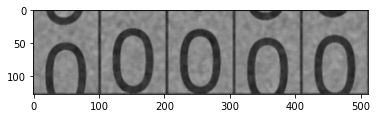

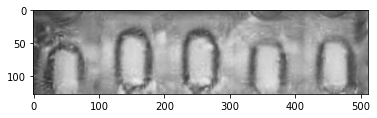

[1, 1, 1, 1, 1]


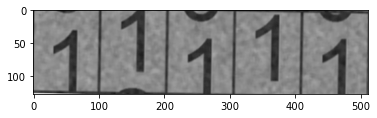

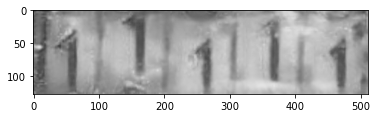

[2, 2, 2, 2, 2]


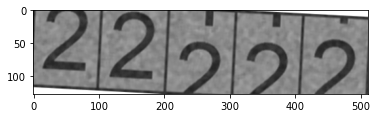

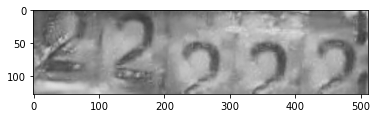

[3, 3, 3, 3, 3]


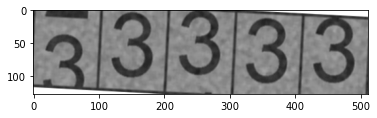

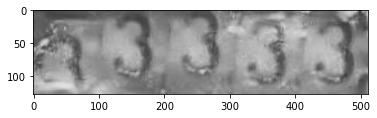

[4, 4, 4, 4, 4]


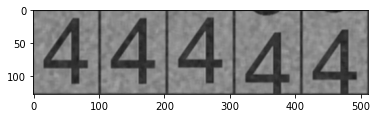

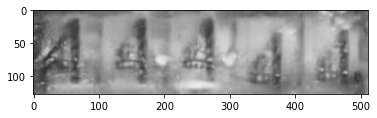

[5, 5, 5, 5, 5]


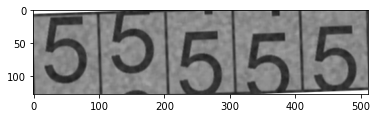

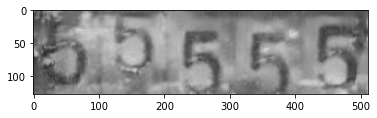

[6, 6, 6, 6, 6]


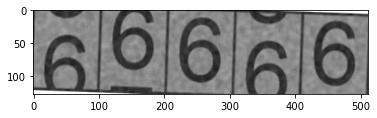

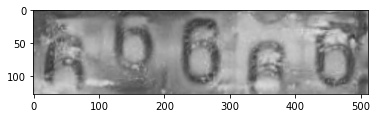

[7, 7, 7, 7, 7]


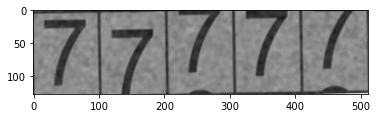

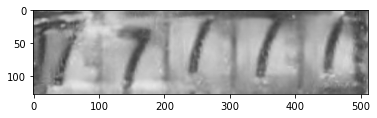

[8, 8, 8, 8, 8]


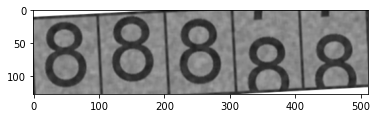

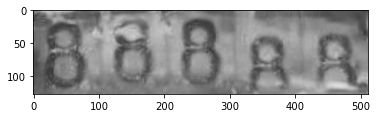

[9, 9, 9, 9, 9]


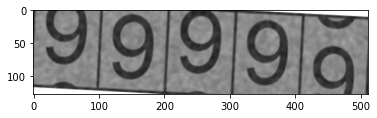

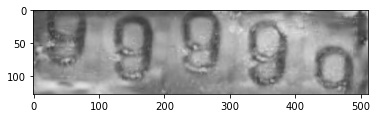

[10, 10, 10, 10, 10]


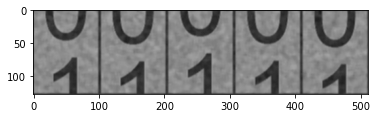

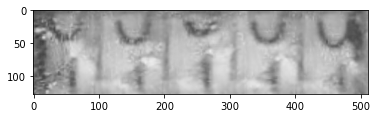

[11, 11, 11, 11, 11]


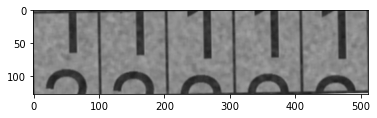

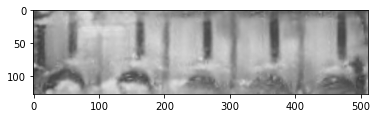

[12, 12, 12, 12, 12]


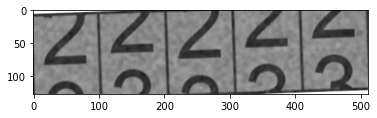

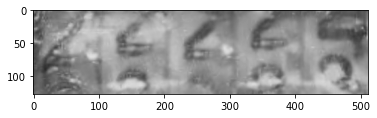

[13, 13, 13, 13, 13]


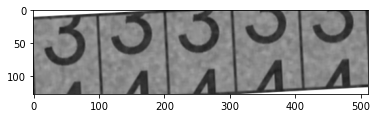

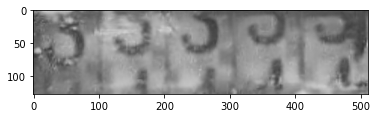

[14, 14, 14, 14, 14]


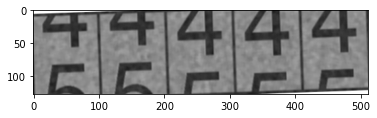

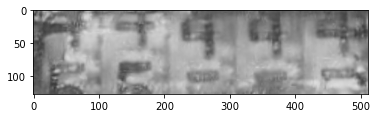

[15, 15, 15, 15, 15]


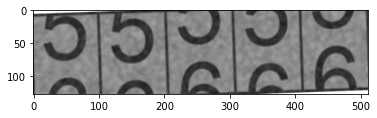

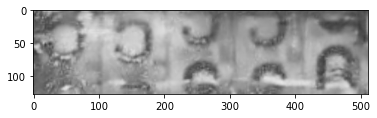

[16, 16, 16, 16, 16]


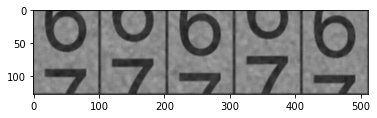

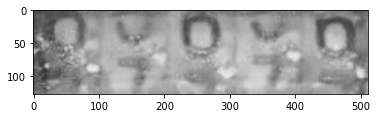

[17, 17, 17, 17, 17]


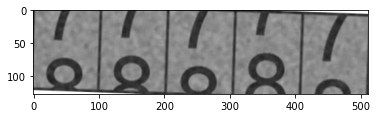

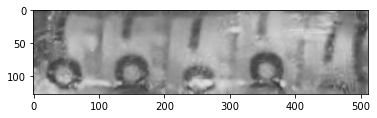

[18, 18, 18, 18, 18]


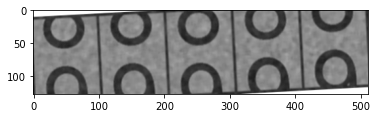

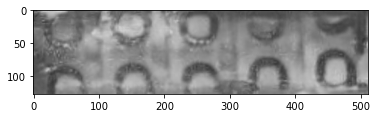

[19, 19, 19, 19, 19]


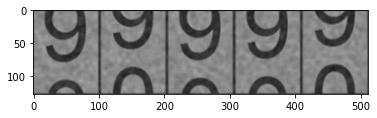

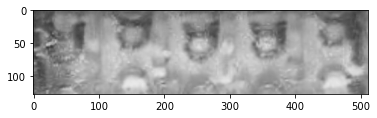

In [11]:
# show label, input and output
for i in range(N_IMAGES):
    print(labels[i])
    showImage(images_synth[i])
    showImage(images_gen[i])